In [40]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.functional import F
from torch_geometric.nn import to_hetero
from torch_geometric.loader import DataLoader

#### Set random seed

In [13]:
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#### Set device and parameters

In [14]:
# Set hyper-parameters
input_dim = 8
hidden_dim = 64
output_dim = 1

# Set batch size
batch_size = 10

# Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Directory of the dataset
train_dir = f'train_dataset'
test_dir = f'test_dataset'

#### Load train and test data

In [15]:
from CustomDataset import CustomDataset

In [16]:
train_dataset = CustomDataset(root=train_dir, data_list=[])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(root=test_dir, data_list=[])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Load model

In [17]:
from GNNModel import GNNModel

model = GNNModel(input_dim, hidden_dim, output_dim)
model = to_hetero(module=model, 
                  metadata=train_loader.dataset[0].metadata(), 
                  aggr='mean')
model.to(device)
model

GraphModule(
  (conv1): ModuleDict(
    (node__branch__node): GCNConv(8, 64)
    (node__trafo__node): GCNConv(8, 64)
  )
  (bn1): ModuleDict(
    (node): BatchNorm(64)
  )
  (in1): ModuleDict(
    (node): InstanceNorm(64)
  )
  (ln1): ModuleDict(
    (node): LayerNorm(64, affine=True, mode=graph)
  )
  (conv2): ModuleDict(
    (node__branch__node): GCNConv(64, 64)
    (node__trafo__node): GCNConv(64, 64)
  )
  (bn2): ModuleDict(
    (node): BatchNorm(64)
  )
  (in2): ModuleDict(
    (node): InstanceNorm(64)
  )
  (ln2): ModuleDict(
    (node): LayerNorm(64, affine=True, mode=graph)
  )
  (conv3): ModuleDict(
    (node__branch__node): GCNConv(64, 1)
    (node__trafo__node): GCNConv(64, 1)
  )
  (bn3): ModuleDict(
    (node): BatchNorm(1)
  )
  (in3): ModuleDict(
    (node): InstanceNorm(1)
  )
  (ln3): ModuleDict(
    (node): LayerNorm(1, affine=True, mode=graph)
  )
)

#### Train model

In [18]:
# Set number of epochs
epochs = 1000

# Set optimizer
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
)

# Set model to training mode
model.train()

# Model training
epoch_loss = []
start_time = time.time()

for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)
        optimizer.zero_grad()
        out = model(loader.x_dict, loader.edge_index_dict)
        loss = F.mse_loss(out['node'][loader.mask], loader['node'].y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

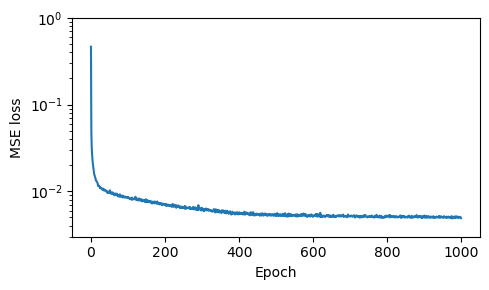

In [82]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

ax.plot(epoch_loss)
ax.set_ylim(3e-3, 1)
ax.set_yscale('log')


ax.set_xlabel('Epochs')
ax.set_ylabel('MSE loss')

plt.tight_layout()
plt.show()
plt.close('all')

#### Save model

In [20]:
torch.save(model, 'trained_model/trained_model.pt')

#### Test model

In [83]:
## Set evaluation mode
model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []
    for loader in test_loader:
        loader.to(device)
        out = model(loader.x_dict, loader.edge_index_dict)
        y_true.append(loader['node'].y.cpu().numpy())
        y_pred.append(out['node'][loader.mask].cpu().numpy())

In [85]:
## Save model predictions
y_true = np.array(y_true).reshape((300, -1)).T
y_pred = np.array(y_pred).reshape((300, -1)).T

pd.DataFrame(y_true).to_csv('model_prediction/y_true.csv', 
                            index=False,
                            header=False)
pd.DataFrame(y_pred).to_csv('model_prediction/y_pred.csv', 
                            index=False,
                            header=False)

In [86]:
error = np.abs((y_true - y_pred) / y_true) * 100
error = error.flatten()

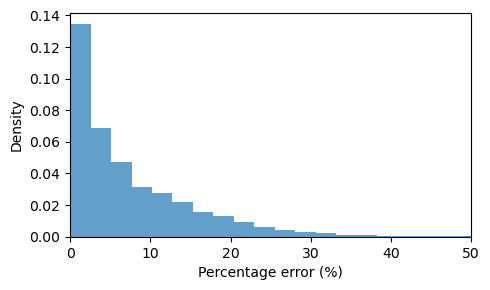

In [89]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

_, _, _ = ax.hist(error, bins=200, alpha=0.7, density=True)
ax.set_xlim(0, 50)
ax.set_xlabel('Percentage error (%)')
ax.set_ylabel('Density')

plt.tight_layout()
plt.show()
plt.close('all')